# Preparation
Install python requirements

In [ ]:
!pip install branca jinja2 requests folium geoip2 dnspython
!pip install --upgrade folium matplotlib

     |████████████████████████████████| 269 kB 19.3 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 1.1 MB 53.2 MB/s 
     |████████████████████████████████| 127 kB 50.5 MB/s 
     |████████████████████████████████| 330 kB 60.7 MB/s 
     |████████████████████████████████| 144 kB 55.5 MB/s 
     |████████████████████████████████| 271 kB 62.6 MB/s 
     |████████████████████████████████| 94 kB 4.1 MB/s 
  Created wheel for maxminddb: filename=maxminddb-2.2.0-py2.py3-none-any.whl size=16356 sha256=ddba34a93871b27102377b856558af205fde526967b328c8507ac7a52b1dbc1a
  Stored in directory: /root/.cache/pip/wheels/3b/eb/d9/b4407ec5d0ccddce61c8d2f4db72a68a77a04adea2245b98ef
Successfully built maxminddb
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
   

# Data gathering
Downloading full crawled list by SIPA

In [ ]:
# curl https://bitcoin.sipa.be/seeds.txt.gz | gzip -dc > seeds_main.txt
import subprocess

with open("seeds_main.txt","w") as out:
    curl_process = subprocess.Popen(['curl', 'https://bitcoin.sipa.be/seeds.txt.gz'],
                         stdout=subprocess.PIPE, 
                         stderr=subprocess.PIPE)

    gzip_process = subprocess.Popen(['gzip', '-dc'],
                         stdin=curl_process.stdout,
                         stdout=subprocess.PIPE, 
                         stderr=subprocess.PIPE)

    curl_process.stdout.close()
    stdout, stderr = gzip_process.communicate()
    gzip_process.wait()
    out.write(stdout.decode("utf-8"))

with open("seeds_main.txt") as myfile:
    for i in range(10):
      print(next(myfile).strip())

# address                                        good  lastSuccess    %(2h)   %(8h)   %(1d)   %(7d)  %(30d)  blocks      svcs  version
63.32.134.196:8333                                  0   1649226150  100.00% 100.00% 100.00% 100.00% 100.00%  730655  0000000c  70015 "/Satoshi:0.14.99/"
35.175.55.104:8333                                  0   1649226633  100.00% 100.00% 100.00% 100.00% 100.00%  730655  0000000c  70015 "/Satoshi:0.14.99/"
85.10.201.29:8446                                   0   1649226526  100.00% 100.00% 100.00% 100.00% 100.00%  1756745  0000040d  70016 "/Satoshi:0.18.7/"
20.184.15.116:8433                                  0   1649226514  100.00% 100.00% 100.00% 100.00% 100.00%  730655  00000409  70016 "/Satoshi:22.0.0/"
49.12.126.6:9001                                    0   1649226468  100.00% 100.00% 100.00% 100.00% 100.00%  730655  00000409  70016 "/Satoshi:22.0.0/"
34.252.220.98:8333                                  0   1649226237  100.00% 100.00% 100.00% 100.00% 10

Load data in Pandas and transform it

In [ ]:
import pandas as pd
columns = ['address','good','lastSuccess', '%(2h)', '%(8h)', '%(1d)', '%(7d)', '%(30d)', 'blocks', 'svcs', 'version','Satoshi_v']
df = pd.read_csv("seeds_main.txt",delimiter=r"\s+",names=columns,header=None,skiprows=1)

perc_list = ['%(2h)', '%(8h)', '%(1d)', '%(7d)', '%(30d)']

for key in perc_list:
    df[key] = df[key].str.rstrip('%').astype('float')

tor_nodes = df['address'].str.match(r".*onion.*")
regular_nodes = ~tor_nodes
regular_nodes_online = df[regular_nodes].loc[df['%(30d)'] > 50]

# More data gathering
Download data enriched by [Bitnodes](https://bitnodes.io/api/#list-nodes). Data is NOT complete, but a good start to work with.

In [ ]:
import requests
import json

bitnodes_snapshots = requests.get('https://bitnodes.io/api/v1/snapshots/').json()
bitnodes_nodes = requests.get(bitnodes_snapshots['results'][0]['url']).json()
bitnodes_json = bitnodes_nodes
with open('bitnode_nodes.json', 'w') as f:
    json.dump(bitnodes_nodes, f, indent=4)

# Prepare GeoIP database
Download GeoIP databases from MaxMind and unzip them.
Put your personal license key from [Maxmind](https://www.maxmind.com/) in the variable `maxmind_license_key`

In [ ]:
import tarfile
import requests
import os

maxmind_license_key = "O68fUuUt86sgesDW"
maxmind_asn_url = 'https://download.maxmind.com/app/geoip_download?edition_id=GeoLite2-ASN&license_key={}&suffix=tar.gz'.format(maxmind_license_key)
maxmind_city_url = 'https://download.maxmind.com/app/geoip_download?edition_id=GeoLite2-City&license_key={}&suffix=tar.gz'.format(maxmind_license_key)
maxmind_asn_tarname = "geolite2_asn.tar.gz"
maxmind_city_tarname = "geolite2_city.tar.gz"

# mapping function for rewrite extract path
def rewrite_extract_path(tar_item):
  tar_item.name = os.path.basename(tar_item.name)
  return tar_item

# Download files from maxmind
with open(maxmind_asn_tarname,"wb") as out:
    r = requests.get(maxmind_asn_url, allow_redirects=True)
    out.write(r.content)


with open(maxmind_city_tarname,"wb") as out:
    r = requests.get(maxmind_city_url, allow_redirects=True)
    out.write(r.content)


# Extract files
asn_tar = tarfile.open(maxmind_asn_tarname)
asn_tar.extractall(members=map(rewrite_extract_path, [x for x in asn_tar.getmembers() if 'GeoLite2-ASN.mmdb' in x.name]))
asn_tar.close()
asn_city = tarfile.open(maxmind_city_tarname)
asn_city.extractall(members=map(rewrite_extract_path, [x for x in asn_city.getmembers() if 'GeoLite2-City.mmdb' in x.name]))
asn_city.close()

# Data enrichment
Check if data about an endpoint is already enriched by bitnodes. If not, use the Maxmind databases and DNS to enrich the data. Google DNS is used as DNS resolver.

In [ ]:
import geoip2.database
import re
import dns.resolver


my_resolver = dns.resolver.Resolver()
my_resolver.nameservers = ['8.8.8.8']

ip_address_regex = re.compile(r'(\[(?P<v6>.*)\]|(?P<v4>.*)):(?P<port>\d{1,})')

with geoip2.database.Reader('GeoLite2-City.mmdb') as geoip_r:
  with geoip2.database.Reader('GeoLite2-ASN.mmdb') as geo_asn_r:
    not_found = 0
    for index, row in regular_nodes_online.iterrows():
      if row['address'] not in bitnodes_json['nodes']:
        m = ip_address_regex.match(row['address'])
        search_ip = row['address']
        if m:
          if m.groupdict()['v4'] is not None:
            search_ip = m.groupdict()['v4']
          elif m.groupdict()['v6'] is not None:
            search_ip = m.groupdict()['v6']
          else:
            print('Regex not matching for IP {}'.format(row['address']))
            continue
        # Search IP in City DB
        try:
          city = geoip_r.city(search_ip)
        except:
          print("IP address {} not found in GeoIP db.".format(row['address']))
          continue
        # Add geoip to data structure
        bitnodes_json['nodes'][row['address']] = [None] * 13
        bitnodes_json['nodes'][row['address']][8] = city.location.latitude
        bitnodes_json['nodes'][row['address']][9] = city.location.longitude
        bitnodes_json['nodes'][row['address']][6] = city.city.name
        bitnodes_json['nodes'][row['address']][7] = city.country.iso_code
        
        # Add ASN to datastructure
        try:
          asn = geo_asn_r.asn(search_ip)
        except:
          print("IP address {} not found in ASN db.".format(row['address']))
          continue

        bitnodes_json['nodes'][row['address']][11] = asn.autonomous_system_number
        bitnodes_json['nodes'][row['address']][12] = asn.autonomous_system_organization

        # Retrieve hostname
        try:
          result = my_resolver.resolve_address(search_ip)
          hostname = result[0].to_text()
        except:
          hostname = "unknown"
        bitnodes_json['nodes'][row['address']][5] = hostname
        # Add new column
        regular_nodes_online.loc[index, 'asn'] = asn.autonomous_system_number
        regular_nodes_online.loc[index, 'org'] = asn.autonomous_system_organization
        regular_nodes_online.loc[index, 'country'] = city.country.iso_code
        regular_nodes_online.loc[index, 'hostname'] = hostname
      else:
        # Add new column
        regular_nodes_online.loc[index, 'asn'] = bitnodes_json['nodes'][row['address']][11]
        regular_nodes_online.loc[index, 'org'] = bitnodes_json['nodes'][row['address']][12]
        regular_nodes_online.loc[index, 'country'] = bitnodes_json['nodes'][row['address']][7]
        regular_nodes_online.loc[index, 'hostname'] = bitnodes_json['nodes'][row['address']][5]
        

with open('bitnode_nodes.json', 'w') as f:
    json.dump(bitnodes_json, f, indent=4)

IP address 0.0.0.0:8333 not found in GeoIP db.
IP address [2602:ffe8:100:2::9d20:2e3c]:8333 not found in GeoIP db.
IP address [200:419f:63fe:40eb:1d13:9000:74b:ae8b]:8333 not found in GeoIP db.
IP address [::]:8333 not found in GeoIP db.
IP address [200:8a8:d3d7:8f91:d347:37ea:6ee4:8c18]:8333 not found in GeoIP db.


In [ ]:
import json

try: bitnodes_json
except:
  with open('bitnode_nodes.json','r' ) as file:
    bitnodes_json = json.load(file)

asn = []
country = []
for index, row in regular_nodes_online.iterrows():
  if row['address'] not in bitnodes_json['nodes']:
    continue
  extra_data = bitnodes_json['nodes'][row['address']]
  if extra_data[11]:
    extra_data[11] = int(extra_data[11].replace('AS','')) if isinstance(extra_data[11], str) else extra_data[11]
  else:
    extra_data[11] = 0
  regular_nodes_online.loc[index, 'asn'] = extra_data[11]
  regular_nodes_online.loc[index, 'country'] = extra_data[7]
  regular_nodes_online.loc[index, 'org'] = extra_data[12]
  if extra_data[5] is not None:
    regular_nodes_online.loc[index, 'hostname'] = extra_data[5] if extra_data[5].endswith('.') else extra_data[5]+'.'
  else:
    regular_nodes_online.loc[index, 'hostname'] = extra_data[5]

# Bitcoin Nodes grouped by Connectivity
Bitcoin nodes grouped by their address type. IPv4, IPv6 or TOR.

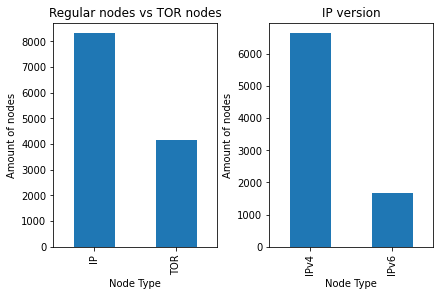

In [ ]:
import matplotlib.pyplot as plt

v4_regex = r'[0-9\.]+:\d{1,}'
v6_regex = r'\[.*\]:(?P<port>\d{1,})'

v4_nodes = regular_nodes_online.loc[df['address'].str.match(v4_regex)].count()
v6_nodes = regular_nodes_online.loc[df['address'].str.match(v6_regex)].count()
tor_nodes_count = df[tor_nodes].loc[df['%(1d)'] > 10].count()
regular_nodes_count = regular_nodes_online.count()
count_tor_df = pd.DataFrame({'IP': regular_nodes_count, 'TOR': tor_nodes_count})
count_ipver_df = pd.DataFrame({'IPv4': v4_nodes, 'IPv6': v6_nodes})
fig, axes = plt.subplots(nrows=1, ncols=2,  constrained_layout=True)
#subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

#count_df.plot(kind='bar', stacked=True)
axes[0].set_title("Regular nodes vs TOR nodes")
axes[1].set_title("IP version")
count_tor_df.iloc[0].plot(kind='bar',ax=axes[0], ylabel="Amount of nodes", xlabel="Node Type")
count_ipver_df.iloc[0].plot(kind='bar',ax=axes[1], ylabel="Amount of nodes", xlabel="Node Type")
plt.show()

# Bitcoin Client Version

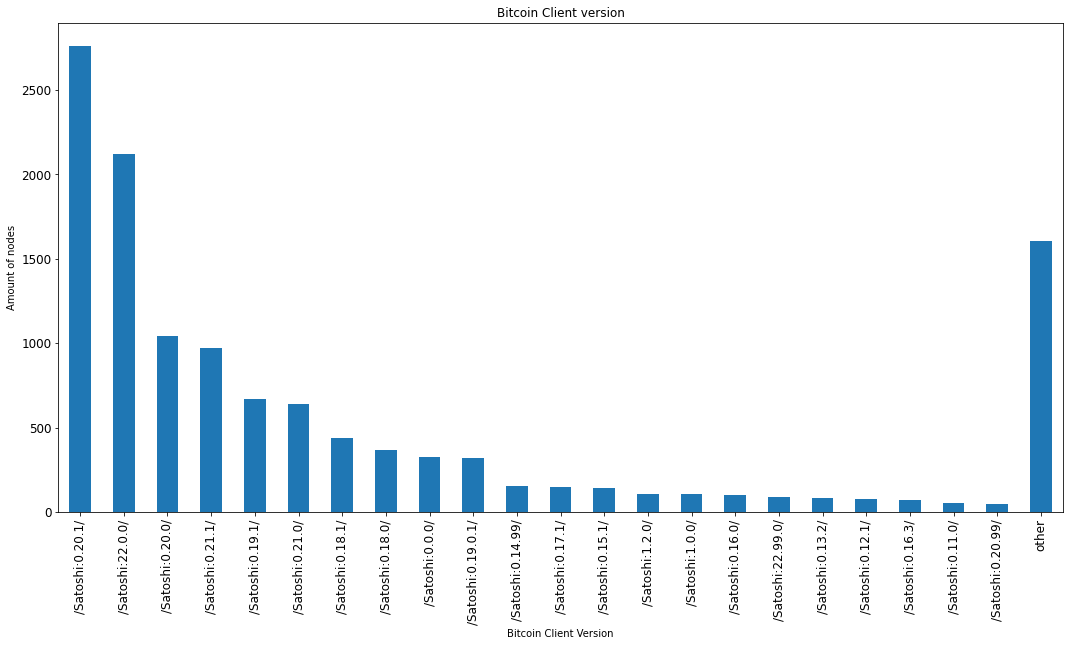

In [ ]:
import matplotlib.pyplot as plt

total_online_nodes = pd.concat([df[tor_nodes].loc[df['%(1d)'] > 10], regular_nodes_online])
# Group by Satoshi version
bitcoin_version_df = total_online_nodes.groupby(by="Satoshi_v").count()
# Get only versions which have more than 50 entries. Otherwise group them together to category "other"
major_btc_version_df = bitcoin_version_df.loc[bitcoin_version_df['address'] > 50].sort_values(by=['address'], ascending=False)
major_btc_version_df.loc['other'] = bitcoin_version_df.loc[bitcoin_version_df['address'] <= 50].sum()['address']
major_btc_version_df['address'].plot(kind='bar',ylabel="Amount of nodes", xlabel="Bitcoin Client Version", figsize=(18, 9), fontsize=12)
plt.title("Bitcoin Client version")
plt.show()

# Bitcoin Nodes grouped by ASN

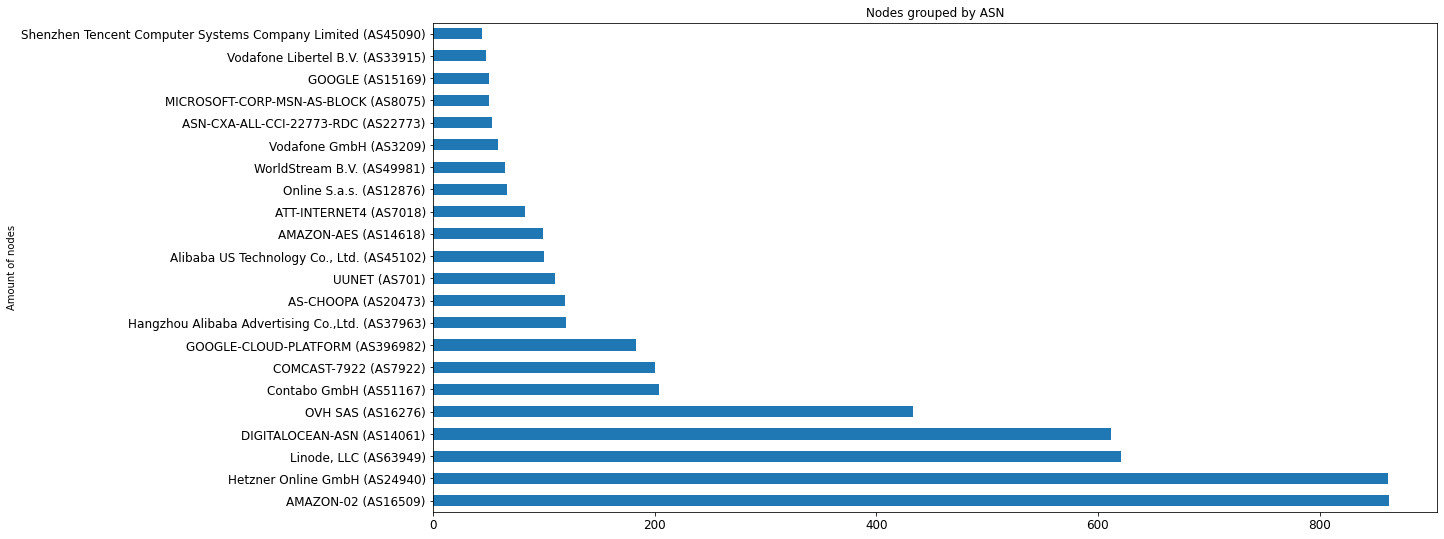

In [ ]:
asn_org_grouped = regular_nodes_online.groupby(by=["asn", "org"]).count().sort_values(by="address", ascending=False)
asn_org_major_df = asn_org_grouped['address'].loc[asn_org_grouped['address'] > 40]
#asn_org_major_df.loc[(0.0, 'other')] = asn_org_grouped.loc[asn_org_grouped['address'] <= 40].sum()['address']

ax = asn_org_major_df.plot(kind='barh',xlabel="Amount of nodes", ylabel="ASN", figsize=(18, 9), fontsize=12)
# Format x labels
xlabels = ["{1} (AS{0:0.0f})".format(item[0], item[1]) for item in asn_org_major_df.index.tolist()]
ax.set_yticklabels(xlabels)
ax.set_title("Nodes grouped by ASN")
plt.show()

# Bitcoin Nodes grouped by Country

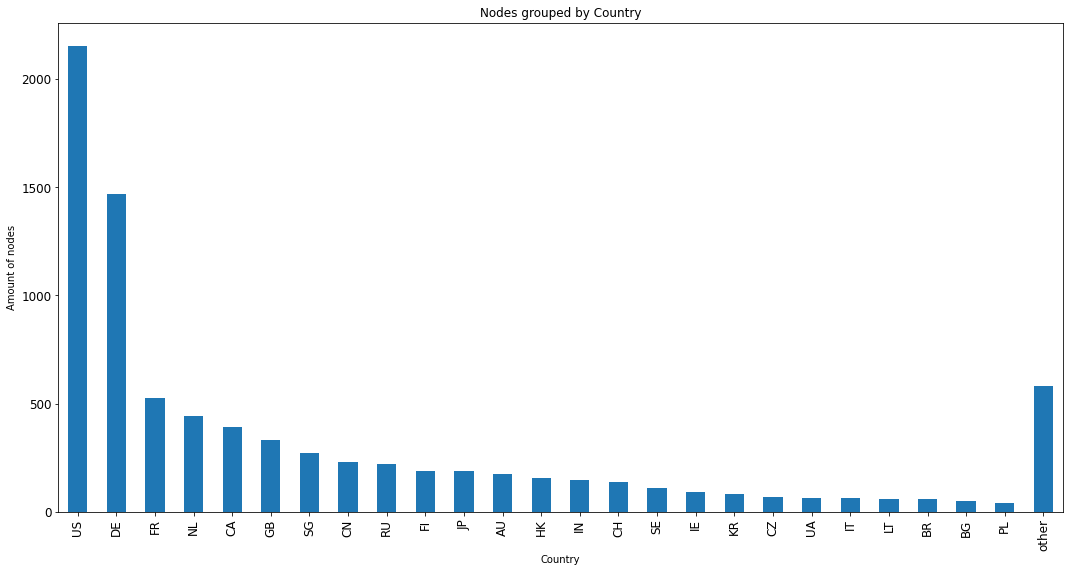

In [ ]:
country_grouped_df = regular_nodes_online.groupby(by="country").count().sort_values(by="address", ascending=False)
country_major_grouped_df = country_grouped_df['address'].loc[country_grouped_df['address'] > 40]
country_major_grouped_df.loc['other'] = country_grouped_df.loc[country_grouped_df['address'] <= 40].sum()['address']

ax = country_major_grouped_df.plot(kind='bar',ylabel="Amount of nodes", xlabel="Country", figsize=(18, 9), fontsize=12)
# Format x labels
ax.set_title("Nodes grouped by Country")
plt.show()

# Bitcoin Nodes grouped by domain

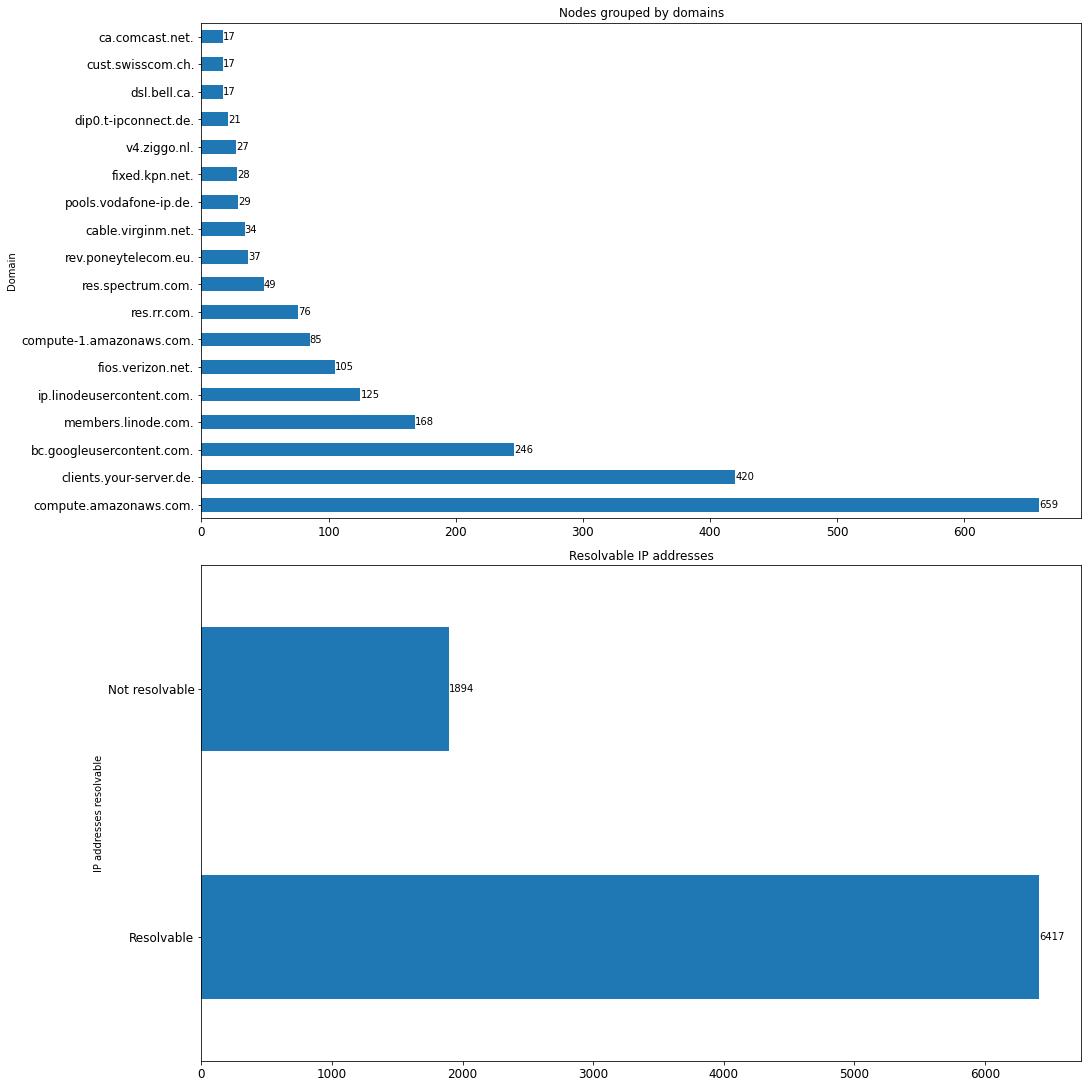

In [ ]:
import matplotlib.pyplot as plt

hostname_df = regular_nodes_online.copy().loc[(regular_nodes_online['hostname'].notnull()) & (regular_nodes_online['hostname'] != "unknown.")]
hostname_df['hostname'] = hostname_df['hostname'].str.split(pat='.').str[-4:].str.join('.')
not_resolved_df = regular_nodes_online.copy().loc[(regular_nodes_online['hostname'].isnull()) | (regular_nodes_online['hostname'] == "unknown.")]
hostname_grouped_df = hostname_df.groupby(by="hostname").count().sort_values(by="address", ascending=False)
hostname_major_df = hostname_grouped_df.loc[hostname_grouped_df['address'] > 16]
#hostname_major_df.head(10)

fig, axes = plt.subplots(nrows=2, ncols=1,  constrained_layout=True, figsize=(15,15))

ax = hostname_major_df['address'].plot(kind="barh", xlabel="Domain", fontsize=12, ax=axes[0])
ax.bar_label(ax.containers[0], fmt='%.0f')


count_hostname_resolvable_count = hostname_df.count()
count_resolvable_count_df = pd.DataFrame({'Resolvable': count_hostname_resolvable_count, 'Not resolvable': not_resolved_df.count()})
ax2 = count_resolvable_count_df.iloc[0].plot.barh(ax=axes[1], ylabel="Amount of nodes", xlabel="IP addresses resolvable", fontsize=12)
ax2.bar_label(ax2.containers[0], fmt='%.0f')
axes[0].set_title("Nodes grouped by domains")
axes[1].set_title("Resolvable IP addresses")
plt.show()

# Visualization
This map shows all Bitcoin nodes from mainnet. ASN and the organization name of the ASN is shown in the popup.

In [ ]:
import folium
import folium.plugins as plugins
import json
from datetime import datetime
import re

# Callback for the marker
# The code needs to in Javascript!!
fastmap_callback = """
  function (row) {
    var icon = L.AwesomeMarkers.icon({'prefix': 'fa', 'icon': 'bitcoin'});
    var popup = L.popup().setContent(
      `<p><strong>Endpoint:</strong> ${row[2]}<br />
      <strong>Hostname:</strong> ${row[7]}<br />
      <strong>ASN:</strong> ${row[3]}<br />
      <strong>Organization:</strong> ${row[4]}<br />
      <strong>Bitcoin Software Version:</strong> ${row[6]}<br />
      <strong>Last Seen:</strong> ${row[5]}<br />
      </p>`
    );
    var marker = L.marker(new L.LatLng(row[0], row[1]));
    marker.setIcon(icon);
    marker.bindPopup(popup);
    return marker;
  };"""

bitcoin_version_regex = re.compile(r'\/Satoshi\:(?P<version>[0-9.]+)\/')

if bitnodes_json is None:
  with open('bitnode_nodes.json','r' ) as file:
    bitnodes_json = json.load(file)

# Create Map
btc_map = folium.Map(zoom_start=1)
not_found = 0
markers = []

# Prepare markers
for index, row in regular_nodes_online.iterrows():
  if row['address'] not in bitnodes_json['nodes']:
    not_found += 1
    continue
  extra_data = bitnodes_json['nodes'][row['address']]
  # Parse last seen timestamp
  last_success = datetime.utcfromtimestamp(row['lastSuccess']).strftime('%d.%m.%Y')
  # Parse version number
  re_match = bitcoin_version_regex.match(str(row['Satoshi_v']))
  version = "unknown"
  if re_match:
    version = re_match.groupdict()['version']
  markers.append((extra_data[8], extra_data[9], row['address'], extra_data[11], extra_data[12], last_success, version, extra_data[5]))

# Add markers to map
plugins.FastMarkerCluster(markers, fastmap_callback).add_to(btc_map)
# Show map
btc_map